TGV Method based on [TVL-1](https://github.com/znah/notebooks/blob/master/TV_denoise.ipynb)

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image
from numpy import hstack, ones
from numpy.matlib import rand
from matplotlib.pyplot import imread
import matplotlib.pylab as plt
from scipy.ndimage import imread
import matplotlib

from scipy.misc import ascent


# routine

def showarray(a):
    _, data = cv2.imencode('.png', a)
    display(Image(data.tostring(), format='png'))


def make_noisy(img):
    # add gaussian noise
    mean = 4.0  # some constant
    std = 1.0  # some constant (standard deviation)
    img = img + 5 * np.random.normal(mean, std, size=img.shape)
    # add some outliers in on the right side of the image
    m = np.random.rand(*img.shape) < 0.2
    m[:, :160] = 0
    img[m] = np.random.randint(0, 255, m.sum())
    return img


def make_spotty(img, r=3, n=1000):
    img = img.copy()
    h, w = img.shape
    for i in range(n):
        x = np.int(rand(1) * (w - r))
        y = np.int(rand(1) * (h - r))
        img[y:y + r, x:x + r] = np.round(np.random.randint(0, 255))
    return img


def generatePlyFile(X, name):
    f = open(name + ".ply", "a")
    f.write("ply\n")
    f.write("format ascii 1.0\n")
    img = X.copy()
    h, w = img.shape
    f.write("element vertex " + str(h * w) + "\n")
    f.write("property float x\n")
    f.write("property float y\n")
    f.write("property float z\n")
    f.write("element face " + str((w - 2) + (h - 1) * w) * 2 + "\n")
    f.write("property list uint8 int32 vertex_indices\n")
    f.write("end_header\n")
    for i in range(0, h):
        for j in range(0, w):
            f.write(str(i) + " " + str(j) + " " + str(img[i][j]) + "\n")

    amount = 0
    for i in range(0, h - 1):
        for j in range(0, w - 1):
            a = w * i + j
            b = w * i + j + 1
            c = (w) * i + j + w
            d = (w) * i + j + 1 + w
            amount += 2
            f.write("3 " + str(a) + " " + str(b) + " " + str(c) + "\n")
            f.write("3 " + str(c) + " " + str(b) + " " + str(d) + "\n")



In [2]:
# math routine


def anorm(x):
    '''Calculate L2 norm over the last array dimention'''
    return np.sqrt((x * x).sum(-1))


def calc_energy_tgv(u, v):
    energy_tgv = anorm(epsilon(nabla(u))).sum()
    energy_tgv_dual = anorm(epsilon(v)).sum()
    return energy_tgv, energy_tgv_dual


def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] -= I[:, :-1]
    G[:, :-1, 0] += I[:, 1:]
    G[:-1, :, 1] -= I[:-1]
    G[:-1, :, 1] += I[1:]
    return G


def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    # note that we just reversed left and right sides
    # of each line to obtain the transposed operator
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1:] += G[:, :-1, 0]
    I[:-1] -= G[:-1, :, 1]
    I[1:] += G[:-1, :, 1]

    return I


def epsilon(I):
    h, w, _ = I.shape
    G = np.zeros((h, w, 4), I.dtype)
    G[:, :-1, 0] -= I[:, :-1, 0]  # xdx
    G[:, :-1, 0] += I[:, 1:, 0]
    G[:-1, :, 1] -= I[:-1, :, 0]  # xdy
    G[:-1, :, 1] += I[1:, :, 0]
    G[:, :-1, 2] -= I[:, :-1, 1]  # ydx
    G[:, :-1, 2] += I[:, 1:, 1]
    G[:-1, :, 3] -= I[:-1, :, 1]  # ydy
    G[:-1, :, 3] += I[1:, :, 1]
    return G


def epsilonT(G):
    h, w, _ = G.shape
    I = np.zeros((h, w, 2), G.dtype)
    # note that we just reversed left and right sides
    # of each line to obtain the transposed operator
    I[:, :-1, 0] -= G[:, :-1, 0]  # xdx
    I[:, 1:, 0] += G[:, :-1, 0]
    I[:-1, :, 0] -= G[:-1, :, 1]  # xdy
    I[1:, :, 0] += G[:-1, :, 1]
    I[:, :-1, 1] -= G[:, :-1, 2]  # ydx
    I[:, 1:, 1] += G[:, :-1, 2]
    I[:-1, :, 1] -= G[:-1, :, 3]  # ydy
    I[1:, :, 1] += G[:-1, :, 3]

    return I


def project_nd(P, r):
    '''perform a pixel-wise projection onto R-radius balls'''
    if r == 0:
        return np.zeros_like(P)
    nP = np.maximum(1.0, anorm(P) / r)
    return P / nP[..., np.newaxis]



In [5]:

# tgv iteration
NBINS = 8
EMPTY_VALUE = 0

def append_observation(bins_ns, observation, mask):
    for j in range(NBINS):
        cj_from = j*32
        cj_to   = j*32 + 31
        bin_mask = np.logical_and(mask, np.logical_and(observation >= cj_from, observation < cj_to))
        bin_slice = bins_ns[:, :, j]
        bin_slice[bin_mask] += 1


def prox(v, observations, Ws, tau, labmda_data):
    res = np.median(np.dstack(observations+ [v+tau*lambda_data*Ws[k] for k in range(len(observations))]), axis=-1)
    return res
            


def iter_tgv(u, v, p, q, observations, tau, lambda_tv, lambda_tgv, lambda_data, Ws):
    tau_u, tau_v, tau_p, tau_q = tau, tau, tau, tau

    un = prox(u - tau_u * lambda_tv * nablaT(p), observations, Ws, tau_u, lambda_data)
    vn = v + tau_v * (lambda_tgv * (-epsilonT(q)) + lambda_tv * p)

    pn = project_nd(p + tau_p * lambda_tv * (nabla(2 * un - u) - (2 * vn - v)), lambda_tv)

    qn = project_nd(q + tau_q * lambda_tgv * epsilon(2 * vn - v), lambda_tgv)
    return un, vn, pn, qn


def solve(observations, tau, lambda_tv, lambda_tgv, lambda_data, iter_n=101):
    #showarray(observations[0][0])

    height, width = observations[0].shape
    u = np.zeros((height, width), np.float32)
    u[:, :] = observations[0]
    v = np.zeros((height, width, 2), np.float32)
    v = nabla(u)
    p = np.zeros((height, width, 2), np.float32)
    p = nabla(u)
    q = np.zeros((height, width, 4), np.float32)
    q = epsilon(v)
    energies_tv = []
    energies_tgv = []
    energies_tgv_dual = []
    energies_coupling = []
    energies_data = []
    
    Ws = []
    for i in observations:
        result = np.zeros_like(observations[0])
        for j in observations:
            result += i > j
            result -= i < j
        Ws.append(result)
    
    tgv_energy, tgv_energy_dual = calc_energy_tgv(u, v)
    energies_tgv.append(tgv_energy)
    energies_tgv_dual.append(tgv_energy_dual)

    for i in range(iter_n):
        #showarray(u)
        u, v, p, q = iter_tgv(u, v, p, q, observations, tau, lambda_tv, lambda_tgv, lambda_data , Ws)

        tgv_energy, tgv_energy_dual = calc_energy_tgv(u, v)
        energies_tgv.append(tgv_energy)
        energies_tgv_dual.append(tgv_energy_dual)
    return u, v, p, energies_tgv, energies_tgv_dual


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


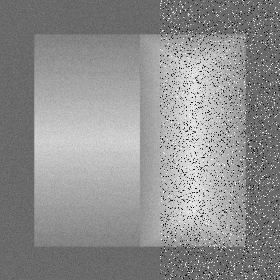

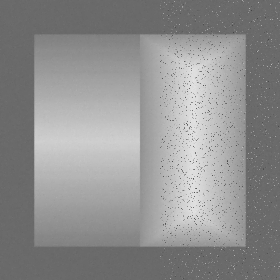

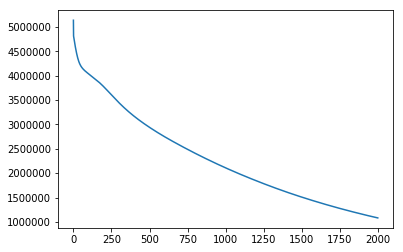

In [4]:

img_ref = imread("house.png", mode='L')

width, height = img_ref.shape

observations = [make_noisy(img_ref) for k in range(10)]



tau         = 1/(8**0.5) / 4/8
lambda_tv   = 1.0
lambda_tgv  = 1.0
lambda_data = 1.0
lambda_tv   /= lambda_data
lambda_tgv  /= lambda_data
showarray(observations[0])
u, v, p, energies_tgv, energies_tgv_dual\
= solve(observations, tau=tau, lambda_tv=lambda_tv, lambda_tgv=lambda_tgv, lambda_data=lambda_data, iter_n=2000)
showarray(u)
plt.plot(energies_tgv)